In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.clr import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(6)
limit_mem()

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

## EDA

In [3]:
args = load_args('../nn_configs/B/81-resnet_d3_dr_0.1.yml')

In [4]:
ds = xr.merge(
    [xr.open_mfdataset(f'{args["datadir"]}/{var}/*.nc', combine='by_coords')
     for var in args["var_dict"].keys()],
    fill_value=0  # For the 'tisr' NaNs
)

In [5]:
ds_train = ds.sel(time=slice('2015', '2015'))

In [6]:
args['data_subsample']=24

In [76]:
dg_train = DataGenerator(
    ds_train, args['var_dict'], 24*61, batch_size=args['batch_size'], output_vars=args['output_vars'],
    data_subsample=args['data_subsample'], norm_subsample=10, nt_in=1, dt_in=1, y_nt=30*24, shuffle=False
)

In [77]:
X, y = dg_train[0]

In [78]:
y.shape

(32, 32, 64, 2)

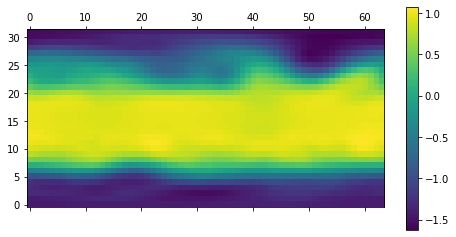

In [79]:
plt.matshow(y[0, ..., 0], origin='lower')
plt.colorbar()

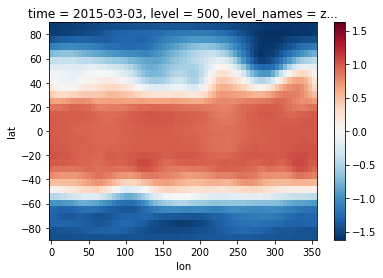

In [70]:
dg_train.data.rolling(time=30).mean().isel(time=61, level=2).plot()

In [17]:
dg_train.data.time

<xarray.DataArray 'time' (time: 365)>
array(['2015-01-01T00:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-03T00:00:00.000000000', ..., '2015-12-29T00:00:00.000000000',
       '2015-12-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
Attributes:
    long_name:  time

In [18]:
dg_train.valid_time

<xarray.DataArray 'time' (time: 304)>
array(['2015-03-03T00:00:00.000000000', '2015-03-04T00:00:00.000000000',
       '2015-03-05T00:00:00.000000000', ..., '2015-12-29T00:00:00.000000000',
       '2015-12-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-03-03 2015-03-04 ... 2015-12-31
Attributes:
    long_name:  time

In [19]:
aggregation = 30

In [23]:
dg_train.data.isel(time=slice(30, 30+aggregation))

<xarray.DataArray 'z' (time: 30, lat: 32, lon: 64, level: 38)>
array([[[[ 0.34184724, -1.0495316 , -1.14165637, ...,  1.44426201,
           2.57085561, -1.67874412],
         [ 0.34133719, -1.04895657, -1.13692611, ...,  1.44426201,
           2.63684811, -1.67874412],
         [ 0.34082714, -1.04780651, -1.13125047, ...,  1.44426201,
           2.70122081, -1.67874412],
         ...,
         [ 0.3438802 , -1.05010526, -1.14449476, ...,  1.44426201,
           2.40688572, -1.67874412],
         [ 0.34286251, -1.05010526, -1.14544014, ...,  1.44426201,
           2.47378905, -1.67874412],
         [ 0.34235488, -1.05010526, -1.14449476, ...,  1.44426201,
           2.52247395, -1.67874412]],

        [[ 0.35659527, -1.0639005 , -1.20504168, ...,  1.44426201,
           2.06275586, -1.57043805],
         [ 0.35557758, -1.06045169, -1.16909145, ...,  1.44426201,
           2.33441714, -1.57043805],
         [ 0.35608521, -1.05240538, -1.13314235, ...,  1.44426201,
           2.4794585 , -1.57043805],
         ...,
         [ 0.36829264, -1.04378404, -1.24477567, ...,  1.44426201,
           1.50808802, -1.57043805],
         [ 0.36371425, -1.0541291 , -1.24288379, ...,  1.44426201,
           1.76416741, -1.57043805],
         [ 0.36015597, -1.06160039, -1.2296395 , ...,  1.44426201,
           1.87833927, -1.57043805]],

        [[ 0.36524199, -1.08631572, -1.2797794 , ...,  1.44426201,
           2.80071523, -1.46213197],
         [ 0.36574963, -1.09436203, -1.2551827 , ...,  1.44426201,
           3.12389527, -1.46213197],
         [ 0.36982038, -1.09148825, -1.22017898, ...,  1.44426201,
           3.37895707, -1.46213197],
         ...,
         [ 0.37744942, -0.96676562, -1.12746333, ...,  1.44426201,
           0.85969458, -1.46213197],
         [ 0.36982038, -1.02136746, -1.22206861, ...,  1.44426201,
           2.03308297, -1.46213197],
         [ 0.36320662, -1.06389914, -1.27599564, ...,  1.44426201,
           2.49159806, -1.46213197]],

        ...,

        [[-1.43977982, -1.34610467, -1.13314235, ..., -0.73436932,
          -0.44150882,  1.46213197],
         [-1.53692436, -1.33633327, -1.1520634 , ..., -0.73436932,
          -0.44090151,  1.46213197],
         [-1.63813482, -1.33863202, -1.17571472, ..., -0.73436932,
          -0.44191369,  1.46213197],
         ...,
         [-1.13563597, -1.35185223, -1.13881799, ..., -0.7343693 ,
          -0.435842  ,  1.46213197],
         [-1.23786412, -1.35989855, -1.1511169 , ..., -0.73436932,
          -0.44120516,  1.46213197],
         [-1.34060232, -1.35989855, -1.13314235, ..., -0.73436932,
          -0.441104  ,  1.46213197]],

        [[-1.7118822 , -1.46910085, -1.19936492, ..., -0.73436932,
          -0.44130638,  1.57043805],
         [-1.77393219, -1.47542344, -1.21450221, ..., -0.73436932,
          -0.44069907,  1.57043805],
         [-1.83343918, -1.4909424 , -1.24572218, ..., -0.73436932,
          -0.44241978,  1.57043805],
         ...,
         [-1.51556016, -1.47484841, -1.24950706, ...,  1.06439006,
          -0.28301559,  1.57043805],
         [-1.58269618, -1.47082593, -1.20882657, ..., -0.29933311,
          -0.39848176,  1.57043805],
         [-1.64779682, -1.46795215, -1.19368927, ..., -0.73436932,
          -0.44373519,  1.57043805]],

        [[-1.75104508, -1.52025387, -1.20882544, ..., -0.73436932,
          -0.44130638,  1.67874412],
         [-1.77393219, -1.52945024, -1.21450221, ..., -0.73436932,
          -0.44110395,  1.67874412],
         [-1.79529399, -1.53864661, -1.22112435, ..., -0.73436932,
          -0.44080029,  1.67874412],
         ...,
         [-1.67475469, -1.49783865, -1.2022033 , ..., -0.73436932,
          -0.43999064,  1.67874412],
         [-1.70069487, -1.50416124, -1.2031498 , ..., -0.73436932,
          -0.44191358,  1.67874412],
         [-1.72663264, -1.51163253, -1.20504168, ..., -0.73436932,
          -0.44161007,  1.67874412]]],


       [[[ 0.29658065, -1.10068462, -1.20409518, ...,  1.44426201,
           2.5

In [32]:
a = dg_train.data.isel(time=slice(0, 30)).mean('time')
a

<xarray.DataArray 'z' (lat: 32, lon: 64, level: 38)>
array([[[ 0.37058176, -1.06706102, -1.15584724, ...,  1.44426201,
          2.57085561, -1.67874412],
        [ 0.37024285, -1.0658541 , -1.15077004, ...,  1.44426201,
          2.63684811, -1.67874412],
        [ 0.37000547, -1.06468542, -1.14556686, ...,  1.44426201,
          2.70122081, -1.67874412],
        ...,
        [ 0.3724974 , -1.06993499, -1.16852419, ...,  1.44426201,
          2.40688572, -1.67874412],
        [ 0.37164989, -1.06918754, -1.16467695, ...,  1.44426201,
          2.47378905, -1.67874412],
        [ 0.37100583, -1.06819142, -1.16041983, ...,  1.44426201,
          2.52247395, -1.67874412]],

       [[ 0.32543514, -1.07489695, -1.17063718, ...,  1.44426201,
          2.06275586, -1.57043805],
        [ 0.32536737, -1.0685363 , -1.1514638 , ...,  1.44426201,
          2.33441714, -1.57043805],
        [ 0.32570644, -1.06152449, -1.13112374, ...,  1.44426201,
          2.4794585 , -1.57043805],
        ...,
        [ 0.33009725, -1.08855701, -1.20907822, ...,  1.44426201,
          1.50808802, -1.57043805],
        [ 0.32770677, -1.08514668, -1.20024847, ...,  1.44426201,
          1.76416741, -1.57043805],
        [ 0.32606219, -1.0803763 , -1.18741392, ...,  1.44426201,
          1.87833927, -1.57043805]],

       [[ 0.26603089, -1.10991856, -1.20901508, ...,  1.44426201,
          2.80071523, -1.46213197],
        [ 0.26740376, -1.09888327, -1.17669176, ...,  1.44426201,
          3.12389527, -1.46213197],
        [ 0.27040445, -1.08700507, -1.14692288, ...,  1.44426201,
          3.37895707, -1.46213197],
        ...,
        [ 0.27152327, -1.12877046, -1.24382958, ...,  1.44426201,
          0.85969458, -1.46213197],
        [ 0.2675733 , -1.12539868, -1.24461815, ...,  1.44426201,
          2.03308297, -1.46213197],
        [ 0.26592864, -1.11967042, -1.23462187, ...,  1.44426201,
          2.49159806, -1.46213197]],

       ...,

       [[-1.27523223, -1.04594843, -0.96411456, ..., -0.73436932,
         -0.44150882,  1.46213197],
        [-1.28386155, -1.03244171, -0.93737291, ..., -0.73436932,
         -0.44090151,  1.46213197],
        [-1.30147626, -1.03269094, -0.92636721, ..., -0.73436932,
         -0.44191369,  1.46213197],
        ...,
        [-1.28981233, -1.13051494, -1.05071016, ..., -0.7343693 ,
         -0.435842  ,  1.46213197],
        [-1.27821575, -1.09725557, -1.02412637, ..., -0.73436932,
         -0.44120516,  1.46213197],
        [-1.27396048, -1.0684029 , -0.99738479, ..., -0.73436932,
         -0.441104  ,  1.46213197]],

       [[-1.47263731, -1.09238863, -0.95490639, ..., -0.73436932,
         -0.44130638,  1.57043805],
        [-1.48508091, -1.09323169, -0.95336123, ..., -0.73436932,
         -0.44069907,  1.57043805],
        [-1.50059344, -1.10125906, -0.95954212, ..., -0.73436932,
         -0.44241978,  1.57043805],
        ...,
        [-1.45230972, -1.12959485, -0.9989297 , ...,  1.06439006,
         -0.28301559,  1.57043805],
        [-1.45688714, -1.11122168, -0.97903111, ..., -0.29933311,
         -0.39848176,  1.57043805],
        [-1.46377028, -1.09886433, -0.96395733, ..., -0.73436932,
         -0.44373519,  1.57043805]],

       [[-1.53961975, -1.25571457, -1.11144594, ..., -0.73436932,
         -0.44130638,  1.67874412],
        [-1.54528238, -1.25923964, -1.11453642, ..., -0.73436932,
         -0.44110395,  1.67874412],
        [-1.55060555, -1.2637994 , -1.1191089 , ..., -0.73436932,
         -0.44080029,  1.67874412],
        ...,
        [-1.52239527, -1.25303233, -1.11097291, ..., -0.73436932,
         -0.43999064,  1.67874412],
        [-1.5282442 , -1.25270662, -1.10971151, ..., -0.73436932,
         -0.44191358,  1.67874412],
        [-1.53397452, -1.25360713, -1.10986929, ..., -0.73436932,
         -0.44161007,  1.67874412]]])
Coordinates:
  * lat          (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon          (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354

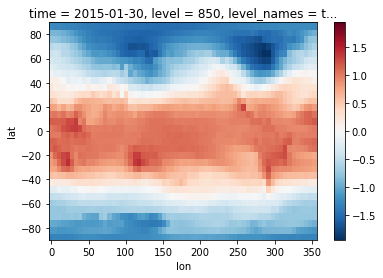

In [60]:
dg_train.data.rolling(time=30).mean().isel(time=29, level=12).plot()

In [25]:
i = 0
idxs = dg_train.idxs[i * dg_train.batch_size:(i + 1) * dg_train.batch_size]

In [28]:
nt = 70
y_nt = 30
y = dg_train.data.isel(
    time=slice(idxs + nt, idxs + nt + y_nt), 
    level=dg_train.output_idxs
)

TypeError: only integer scalar arrays can be converted to a scalar index

## Argh, create script to convert datasets to daily averages

In [81]:
datadir = '/data/stephan/WeatherBench/5.625deg/2m_temperature/'

In [83]:
ds_in = xr.open_mfdataset(f'{datadir}/*.nc', combine='by_coords')

In [84]:
ds_in

,Array,Chunk
Bytes,2.87 GB,71.96 MB
Shape,"(350640, 32, 64)","(8784, 32, 64)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray


In [85]:
avg_hours = 24

In [87]:
dt = dt = ds_in.time.diff('time')[0].values / np.timedelta64(1, 'h')
dt

1.0

In [89]:
nt = int(avg_hours / dt)
nt

24

In [91]:
ds_out = ds_in.rolling(time=nt, center=False, keep_attrs=True).mean()

In [92]:
ds_out.load()

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 nan nan nan ... 250.86975 251.13763
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 07:51:20 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [110]:
save_years = 5

In [95]:
ds_out.time.dt.year.max()

<xarray.DataArray 'year' ()>
array(2018)

In [116]:
savepref = '/test/'
savesuf = '5.625deg.nc'

In [117]:
year_range = (ds_out.time.dt.year.min().values, ds_out.time.dt.year.max().values)

In [123]:
for y in range(*year_range, save_years):
    savefn = f'{savepref}{y if save_years==1 else str(y)+"_"+str(min(y+save_years, year_range[-1]))}_{savesuf}'
    print(savefn)
    ds_save = ds_out.sel(time=slice(str(y), str(y+save_years)))

/test/1979_1984_5.625deg.nc
/test/1984_1989_5.625deg.nc
/test/1989_1994_5.625deg.nc
/test/1994_1999_5.625deg.nc
/test/1999_2004_5.625deg.nc
/test/2004_2009_5.625deg.nc
/test/2009_2014_5.625deg.nc
/test/2014_2018_5.625deg.nc


In [124]:
ds_save

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 43824)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 248.75056 248.27461 ... 251.13763
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 07:51:20 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

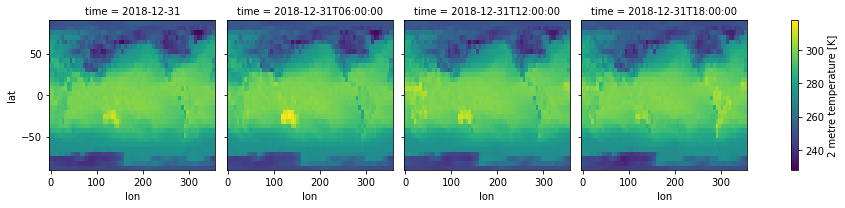

In [128]:
ds_in.t2m.isel(time=slice(-24, None, 6)).plot(col='time')

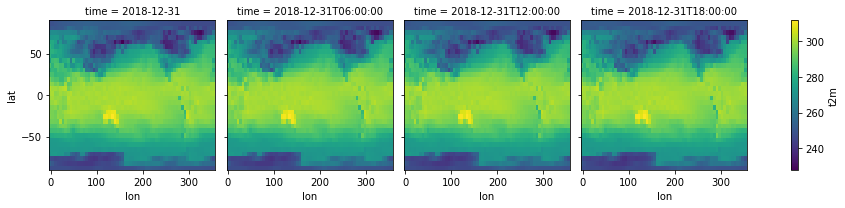

In [129]:
ds_out.t2m.isel(time=slice(-24, None, 6)).plot(col='time')

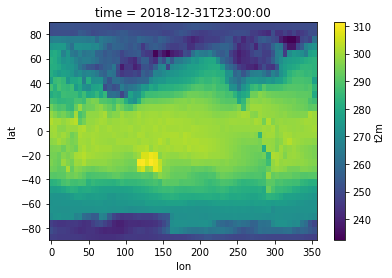

In [127]:
ds_out.t2m.isel(time=-1).plot()

## Test dg

In [162]:
%load_ext line_profiler

In [4]:
args = load_args('../nn_configs/S/001-resnet_t2m_3m.yml')

In [5]:
# args['train_years'] = ['1979', '1980']

In [6]:
dg_train, dg_valid, dg_test = load_data(**args)

In [7]:
dg_train.mean.to_netcdf(f'{args["model_save_dir"]}/{args["exp_id"]}_mean.nc')
dg_train.std.to_netcdf(f'{args["model_save_dir"]}/{args["exp_id"]}_std.nc')

In [195]:
X, y = dg_train[0]

In [196]:
X.shape, y.shape

((32, 32, 64, 117), (32, 32, 64, 1))

In [190]:
dg_train.data

<xarray.DataArray 'z' (time: 730, lat: 32, lon: 64, level: 39)>
array([[[[ 0.77070913, -0.83561919, -0.91057374, ...,  1.44426201,
           2.57085561, -1.67874412],
         [ 0.77205774, -0.83185105, -0.90321424, ...,  1.44426201,
           2.63684811, -1.67874412],
         [ 0.77340315, -0.82745388, -0.8948032 , ...,  1.44426201,
           2.70122081, -1.67874412],
         ...,
         [ 0.76666971, -0.843786  , -0.92318967, ...,  1.44426201,
           2.40688572, -1.67874412],
         [ 0.76801833, -0.84190192, -0.92003631, ...,  1.44426201,
           2.47378905, -1.67874412],
         [ 0.76936373, -0.83876131, -0.91583017, ...,  1.44426201,
           2.52247395, -1.67874412]],

        [[ 0.73299933, -0.93801055, -1.08720049, ...,  1.44426201,
           2.06275586, -1.57043805],
         [ 0.73838736, -0.92544658, -1.05986556, ...,  1.44426201,
           2.33441714, -1.57043805],
         [ 0.7457951 , -0.90974348, -1.02201652, ...,  1.44426201,
           2.4794585 , -1.57043805],
         ...,
         [ 0.7269402 , -0.93424091, -1.08930356, ...,  1.44426201,
           1.50808802, -1.57043805],
         [ 0.72895991, -0.94115117, -1.09876488, ...,  1.44426201,
           1.76416741, -1.57043805],
         [ 0.73165393, -0.94429179, -1.09981642, ...,  1.44426201,
           1.87833927, -1.57043805]],

        [[ 0.64815228, -1.00710866, -1.15133292, ...,  1.44426201,
           2.80071523, -1.46213197],
         [ 0.66229346, -0.99203159, -1.11348388, ...,  1.44426201,
           3.12389527, -1.46213197],
         [ 0.67643463, -0.95559922, -1.08194406, ...,  1.44426201,
           3.37895707, -1.46213197],
         ...,
         [ 0.64815228, -0.9656486 , -1.11243234, ...,  1.44426201,
           0.85969458, -1.46213197],
         [ 0.64209316, -0.98386628, -1.13451084, ...,  1.44426201,
           2.03308297, -1.46213197],
         [ 0.64142206, -1.00271149, -1.15764088, ...,  1.44426201,
           2.49159806, -1.46213197]],

        ...,

        [[-2.64132772, -1.44368014, -1.23123588, ..., -0.73436932,
          -0.44150882,  1.46213197],
         [-2.69587592, -1.49204897, -1.33216456, ..., -0.73436932,
          -0.44090151,  1.46213197],
         [-2.74772368, -1.55046867, -1.45201838, ..., -0.73436932,
          -0.44191369,  1.46213197],
         ...,
         [-2.49722517, -1.31993197, -1.02832323, ..., -0.7343693 ,
          -0.435842  ,  1.46213197],
         [-2.54368811, -1.36139054, -1.08930231, ..., -0.73436932,
          -0.44120516,  1.46213197],
         [-2.58880565, -1.40159256, -1.15448502, ..., -0.73436932,
          -0.441104  ,  1.46213197]],

        [[-2.57533557, -1.35196868, -1.10822745, ..., -0.73436932,
          -0.44130638,  1.57043805],
         [-2.62045632, -1.40661874, -1.19443838, ..., -0.73436932,
          -0.44069907,  1.57043805],
         [-2.66489634, -1.46315438, -1.28905909, ..., -0.73436932,
          -0.44241978,  1.57043805],
         ...,
         [-2.44066047, -1.19995194, -0.91477738, ...,  1.06439006,
          -0.28301559,  1.57043805],
         [-2.48712341, -1.25083386, -0.96734541, ..., -0.29933311,
          -0.39848176,  1.57043805],
         [-2.53022124, -1.30108676, -1.03042631, ..., -0.73436932,
          -0.44373519,  1.57043805]],

        [[-2.37130321, -1.33626559, -1.11979184, ..., -0.73436932,
          -0.44130638,  1.67874412],
         [-2.38813519, -1.35636585, -1.15238445, ..., -0.73436932,
          -0.44110395,  1.67874412],
         [-2.40429928, -1.3764676 , -1.18497581, ..., -0.73436932,
          -0.44080029,  1.67874412],
         ...,
         [-2.31541281, -1.27470526, -1.02937602, ..., -0.73436932,
          -0.43999064,  1.67874412],
         [-2.33493881, -1.29543455, -1.05881402, ..., -0.73436932,
          -0.44191358,  1.67874412],
         [-2.35379371, -1.3155363 , -1.08930231, ..., -0.73436932,
          -0.44161007,  1.67874412]]],


       [[[ 0.74781481, -0.94931648, -1.12609981, ...,  1.44426201,
           2.

In [193]:
dg_train.y_nt

30

In [194]:
dg_train.y_roll[30]

<xarray.DataArray (lat: 32, lon: 64, level: 1)>
array([[[-1.59566634],
        [-1.60869147],
        [-1.62459714],
        ...,
        [-1.5302668 ],
        [-1.55718986],
        [-1.5793903 ]],

       [[-1.29180146],
        [-1.36660047],
        [-1.41540316],
        ...,
        [-1.14651236],
        [-1.24125076],
        [-1.27695945]],

       [[-1.42310168],
        [-1.51369009],
        [-1.61971931],
        ...,
        [-0.83270782],
        [-1.17961465],
        [-1.34319314]],

       ...,

       [[-0.53676539],
        [-0.47135071],
        [-0.5347106 ],
        ...,
        [-1.22729886],
        [-1.08506325],
        [-0.85241948]],

       [[-1.31657094],
        [-1.33973421],
        [-1.36647464],
        ...,
        [-1.66085424],
        [-1.35653639],
        [-1.32246682]],

       [[-1.50913342],
        [-1.53413967],
        [-1.56377751],
        ...,
        [-1.48087202],
        [-1.48424025],
        [-1.49408798]]])
Coordinates:
    time         datetime64[ns] 1979-02-01
  * lat          (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon          (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * level        (level) int64 1
    level_names  (level) <U9 't2m'

In [192]:
%lprun -f dg_train._get_item dg_train[0]

Timer unit: 1e-06 s

Total time: 0.053151 s
File: /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py
Function: _get_item at line 211

Line #      Hits         Time  Per Hit   % Time  Line Contents
   211                                               def _get_item(self, i):
   212                                                   'Generate one batch of data'
   213         1          5.0      5.0      0.0          idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
   214         1          1.0      1.0      0.0          if self.cont_time:
   215                                                       if not self.fixed_time:
   216                                                           if self.min_lead_time is None:
   217                                                               min_nt = 1
   218                                                           else:
   219                                                               min_nt = int(self.min_lea

## Load trained model

In [5]:
args = load_args('../nn_configs/S/001-resnet_t2m_3m.yml')

In [15]:
dg_train, dg_valid, dg_test = load_data(**args)

In [6]:
valid = xr.open_mfdataset(f'{args["datadir"]}/2m_temperature_daily/*.nc',combine='by_coords').isel(time=slice(0, None, 24)).load()

In [8]:
valid_roll = valid.rolling(time=30).mean()

In [11]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_S//001-resnet_t2m_3m.nc').load()

In [12]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 606)
Coordinates:
  * time     (time) datetime64[ns] 2017-05-05 2017-05-06 ... 2018-12-31
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (time, lat, lon) float64 218.7 218.5 218.4 ... 251.3 252.1 252.7

In [13]:
compute_weighted_rmse(preds, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 2.899

In [19]:
model = load_model(args)

In [20]:
dg_train.shuffle = False
dg_train.on_epoch_end()

In [21]:
preds_train = create_predictions(model, dg_train, verbose=1)

419/419 [==============================] - 27s 65ms/step


In [22]:
compute_weighted_rmse(preds_train, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 2.812

In [29]:
def create_monthly_climatology_forecast(ds_train, valid_time):
    monthly_averages = ds_train.groupby(ds_train.time.dt.month).mean('time')
    valid_time['month'] = valid_time['time.month']
    fc_list = []
    for t in valid_time:
        fc_list.append(monthly_averages.sel(month=t.month))
    return xr.concat(fc_list, dim=valid_time)

In [34]:
monthly_climatology = create_monthly_climatology_forecast(
    valid_roll.sel(time=slice('1979', '2015')), valid_roll.sel(time=slice('2017', '2018')).time)

In [35]:
compute_weighted_rmse(monthly_climatology, valid_roll)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.57

In [47]:
monthly_climatology = create_monthly_climatology_forecast(
    valid_roll.sel(time=slice('1981', '2000')), valid_roll.sel(time=slice('2001', '2010')).time)

In [48]:
compute_weighted_rmse(monthly_climatology, valid_roll)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.575

In [36]:
dg_test.valid_time[0]

<xarray.DataArray 'time' ()>
array('2017-05-05T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-05-05
Attributes:
    long_name:  time

In [37]:
X, y = dg_test[0]

In [39]:
y_unnorm = y * dg_test.std[dg_test.output_idxs].values + dg_test.mean[dg_test.output_idxs].values

In [44]:
y_unnorm[0][:5, 0, 0]

array([219.76072141, 230.13807031, 230.86721388, 259.42789656,
       271.31171235])

In [46]:
valid_roll.t2m.sel(time='2017-05-05').values[:5, 0]

array([219.76024, 230.13731, 230.86703, 259.42657, 271.31107],
      dtype=float32)

In [168]:
dg_valid.valid_time

<xarray.DataArray 'time' (time: 242)>
array(['2016-05-04T00:00:00.000000000', '2016-05-05T00:00:00.000000000',
       '2016-05-06T00:00:00.000000000', ..., '2016-12-29T00:00:00.000000000',
       '2016-12-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-05-04 2016-05-05 ... 2016-12-31
Attributes:
    long_name:  time

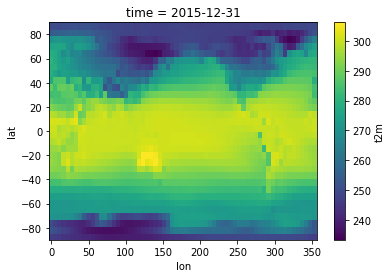

In [164]:
p = preds_train.t2m.isel(time=-1)
p.plot()

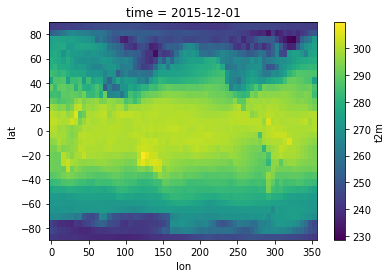

In [172]:
v = valid.t2m.sel(time='2015-12-01')
v.plot()

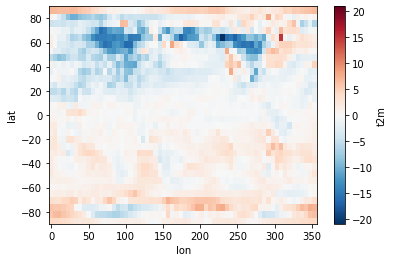

In [173]:
(p - v).plot()

In [41]:
compute_weighted_rmse(preds_train, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 3.262

In [32]:
compute_weighted_rmse(preds, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 2.645

In [42]:
model.evaluate(dg_train, verbose=1)

  ...
    to  
  ['...']
419/419 [==============================] - 30s 71ms/step - loss: 0.1017


0.10167417083122281

In [142]:
model.evaluate(dg_train, verbose=1)

  ...
    to  
  ['...']
419/419 [==============================] - 27s 65ms/step - loss: 0.1017


0.10167091887506494

In [143]:
model.evaluate(dg_valid, verbose=1)

  ...
    to  
  ['...']
8/8 [==============================] - 1s 77ms/step - loss: 0.1019


0.10193360224366188

In [43]:
model.evaluate(dg_test, verbose=1)

  ...
    to  
  ['...']
19/19 [==============================] - 1s 72ms/step - loss: nan


nan

In [33]:
rmse_xy = compute_weighted_rmse(preds, valid, mean_dims=('time')).load()

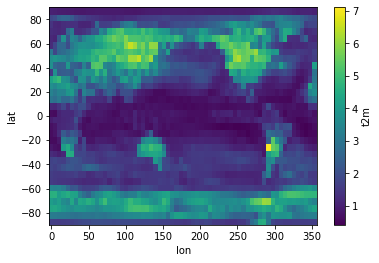

In [35]:
rmse_xy.t2m.plot()